# Leaky Integrate and Fire Neurons and Reservoir Computing - A Demo

The following Notebook is designed to introduce into the topic of leaky integrate and fire neurons and how they can be used in Reservoir networks. It covers the theory behind both concepts and includes some code which shows how the theory is implemented. The notebook is designed as an addition to the course "Neurodynamics" therefore a familiarity with base concepts of neurodynamics is expected.

## 1. Spiking Neuron Models

### 1.1 Biological Neurons vs. Artificial Neurons vs. Spiking Neurons

Both Artificial Neurons and Spiking Neurons are based on biological neurons. Biological neurons can encode information through spike timing and frequencies. If and in what frequency a biological neuron fires depends on the signals the neurons gets as inputs via its dendrites from the previous cells. Some of these inputs are inhibitory and some are excitatory.
Artificial Neurons do not adapt the temporal spect of spiking behavior. Artificial neurons all send out a scalar signal at the same time to the next layer of neurons, where the input is then combined and modified through weights to calculate the next output.
Spiking Neurons, like the name suggests, use spike timings and spike frequencies to encode information. In this regard they are very similar to biological neurons. Most spiking neurons however only model excitatory connections and not inhibitory connections.

![Comparison of Biological neurons, Artificial Neurons and Spiking Neurons (Yamazaki et al., 2022)](img/bnannsnncomparison.png)

### 1.2 Different Spiking Neuron Models

In the course we already learned about some Spiking Neuron Models. The **Hodgkin Huxley Model** models the K+ and Na+ channels, which are the two ion channels that are responsible for the creation of an action potential and a leak reversal potential that models the Cl- ion reversal potential. It is biologically accurate in modeling the membrane potential during spike generation, but it requires large computational ressources and it can not be used to model larger network architectures (Yamazaki et al., 2022).

The **Izhikevich Model** is a two dimensional system that models the upstroke of spike generation and utilizes an auxiliary spike resetting function to model the downstroke. It is much simpler than the Hodgkin Huxley Model and can emulate all known firing patterns of cortical neurons(Yamazaki et al., 2022).

Models can be evaluated in terms of their biological plausiility and their cost of implementation. This graph shows what we touched on above: The Hodgkin-Huxley-Model has a high implementation cost but also models the biological behavior very well. The Izhikevich Model is nearly as biological plausible as the Hodgkin-Huxley Model but is much more efficient. The integrate-and-fire variations are mostly even more efficient than the Inzhikevich Model but they are not as biologically plausible(Yamazaki et al., 2022).

![Comparison of different Spiking Neuron Models (Yamazaki et al., 2022)](img/SNNcomparison.jpg)

In this demo we are covering the **Leaky Integrate and Fire (LIF) Model** as this is the base for most Spiking Neural Networks.

### 1.3 Leaky Integrate-and-Fire Model
For Integrate-and-Fire Models we assume that sub-threshold dynamics of a neuron are a kind of summation process so that inputs to a neuron are summed over time. When a certain threshold is reached, i.e. when there were enough inputs into the neuron, than the neuron spikes and creates an action potential. The moment when the threshold is crossed is called the firing time. The simplest form of Integrate-and-Fire Models is a **Leaky Integrate-and-Fire Model**. To account for a decline in potential over time if the threshold is not reached after an input current, the Leaky Integrate-and-Fire Model adds a leak current which models the drift of ions through the membrane back to the equilibrium. We can derive the model by thinking of the passive membrane as a battery of potential $u_{rest}$ with a capacitator $C$ in parallel with a resistor $R$.

![The membrane portraited as a battery (Gerstner et al., 2014)](img/MembraneAsBattery.png)

The potential of the battery $u_t$ depends on the driving current $I(t)$. The resistor is a passive circuit component with electrical resistance that restricts the flow of the current. The Capacitor is also a passive component that can store electrical charge. The one used for this model is a non-polarized capacitor which means that it does not matter which side is connected to the positive and which side is connected to the negative pole(Gerstner et al., 2014).
If there is no driving current $I(t)$, the voltage at the capacitor is $u_{rest}$, the battery voltage. We can analyse the driving current $I(t)$ by splitting it into two components:

$I(t) = I_R + I_C$

with

$I_R:$ resistive current that passes through linear resistor $R$. Ohm's law describes the relationship between of voltage $u$, resistance $R$ and current $I$ in a conductor as $u = IR$ (Wikipedia, n.d.). We can use this to calculate $I_R = u_R/ R$ with $u_R = u - u_{rest}$ as the voltage across the resistor.

$I_C:$ current that charges the capacitor $C$ when the potential of the electrode changes. The capacitance $C$ of a capacitor is the ratio of charge $q$ and voltage $u$ so that $C = q/u$ (Wikipedia, n.d.). The current flow through a capacitor is the product of the capacitance $C$ and the rate of change of the voltage $du/dt$, so that $I_C = Cdu/dt$.

In combination this gives us:

$I(t) = \frac {u(t) - u_{rest}}{R} + C \frac{du}{dt}$.

The equation is multiplied by $R$ and then the 'leaky integrator' is added as the time constant $τ_m = RC$. This gives us the following formula for the leaky integrator model:

$τ_m\frac{du}{dt} = -[u(t) - u_{rest}] + RI(t) $.

In this model, $u$ represents the mebrane potential, $\tau _m$ the time constant of the neuron, $R$ the resistence of the membrane and $I(t)$ the input current.

When the membrane potential reaches a certain threshold

$u(t^{(f)}) = \theta$,

the neuron spikes. This spike is not modeled explicitly but the timing is noted and the membrane potential is reset immediately to a value $u_r < \theta$ so that:

$\lim_{\delta\to 0, \delta > 0} u (t^{(f)} + \delta) = u_r$ (Gerstner et al., 2014).

**Leaky Integrate-and-Fire Model Summary:**

A leaky Integrate-and-Fire model is therefore defined by the differential equation

$τ_m\frac{du}{dt} = -[u(t) - u_{rest}] + RI(t) $ 

with the reset condition

$\lim_{\delta\to 0, \delta > 0} u (t^{(f)} + \delta) = u_r$.



## 2. Demo

The following demo includes the code for the generation of an input current and a single Integrate-and-Fire neuron with the idea to convey the behavior of the model through playing around with the parameters. We are using the package snntorch for this demo. You can find the documentation for this package under this link: https://snntorch.readthedocs.io/en/latest/#

At the end of the demo you can find the plots for some example parameters that illustrate different behaviors of the model. If you are not interested in the code, you can jump there to learn more about the behavior of the neuron without going through the code explanation.


In [ ]:
import torch
import snntorch as snn
import matplotlib.pyplot as plt
from collections import namedtuple

### 2.1 Input Current

The first step is to implement the input current. The function below includes code for three different types of streams: A continuous stream, a spiking stream with small bursts in regular intervals and sinusodial input waves that change input strength with a set frequency. The length of the input stream is given in time steps. The form of the input streams can be modulated by some different parameters: the parameter $strength$ indicates the highest possible voltage that is put into the neuron. The parameter $frequency$ determines, how fast the current repeats. The value of the frequency indicates how much of the current cycle fits into a single time step. A frequency of 0.1 therefore indicates a spike every ten time steps for the spiking current or for the sinusoidal current that the curve repeats every ten time steps. The sequence length can be calculaated with 1/$frequency$.
The input current is given as a tuple of two 1D input tensors: the time step and the input current at these time steps. 

In [ ]:
def generate_input(params):
    """
    Generates a time series input current based on the specified parameters. This is the input for the spiking neuron of our demo. 
    The function offers three different types of input currents: Sinusoidal, Continuous and Spiking. Sinussoidal currents follow 
    the shape of a sinus function and therefore have changing frequencies between two thresholds. Continuous currents send the same 
    input signal strength the entire time without any variation. Spiking currents send short impulses with pauses inbetween as inputs.

    Args:
        params: An object containing the following attributes:
            - steps (int): The number of time steps to generate.
            - input_type (str): The type of input current. 
              Options include:
              - 'sinusoidal': A sinusoidal current with a specified frequency and strength.
              - 'continuous': A constant current with a fixed strength.
              - 'spiking': A spiking current, where spikes occur at regular intervals 
                based on the specified frequency.
            - strength (float): The magnitude of the input current.
            - frequency (float): The frequency for 'sinusoidal' and 'spiking' input types.

    Returns:
        tuple:
            - time (torch.Tensor): A 1D tensor representing the time steps.
            - input_current (torch.Tensor): A 1D tensor representing the generated 
              input current over time.

    Raises:
        ValueError: If `input_type` is not one of 'sinusoidal', 'continuous', or 'spiking'.

    """
    time = torch.arange(0, params.steps, 1)

    
    if params.input_type == "sinusoidal":
        #creates values for a sinus curve that oscillates between strength and strength/2
        sin_strength = params.strength / 2
        input_current = (
            sin_strength * torch.sin(2 * torch.pi * params.frequency * time)
            + sin_strength
        )
    elif params.input_type == "continuous":
        #creates a continuous inout stream with voltage strength
        input_current = params.strength * torch.ones_like(time, dtype=torch.float32)
    elif params.input_type == "spiking":
        #input current is zero, except for spikes at voltage strength every 1/frequency time steps
        input_current = torch.zeros_like(time, dtype=torch.float32)

        # Calculate spike interval in steps (how many time steps between spikes)
        spike_interval = int(1 / params.frequency)

        # Set the spike values at the appropriate intervals
        for i in range(0, params.steps, spike_interval):
            input_current[i] = params.strength
    else:
        raise ValueError(
            "Invalid input_type. Choose 'sinusoidal', 'continuous' or 'spiking'."
        )
    
    #defines ercentage of time steps that have input current value zero at the beginning and at the end
    zero_percentage = params.steps // 10
    input_current[:zero_percentage] = 0
    input_current[-zero_percentage:] = 0
    return time, input_current

### 2.2 Leaky Integrate-and-Fire neuron

This next function simulates the behavior of a leaky integrate and fire neuron from the package [snntorch](https://snntorch.readthedocs.io/en/latest/#). The snn.Leaky neuron is defined by a beta, which is the decay term by which the membrane potential is reduced, a spiking threshold which defines when the neuron creates a spike and a reset mechanism which defines how the neuron is reset after a spike. This can be a subtracting term or simply setting the membrane potential to zero. In this demo it is based on a subtracting term that subtracts the value of the threshold from the current neuron potential. In combination this can lead to a potential below the resting potential mimicking the hyperpolarization of a neuron. The function records the membrane potential and the spikes the neuron creates over the duration of the input current and saves the behavior in tensors.

In [ ]:
def run_simulation(params):
    """
    Simulates the behavior of a Leaky Integrate-and-Fire (LIF) neuron using an input current.

    Args:
        params: An object containing the following attributes:
            - beta (float): The membrane potential decay factor for the LIF neuron.
            - v_threshold (float): The membrane potential threshold at which the neuron spikes.
            - steps (int): The number of time steps to simulate.
            - input_type (str): The type of input current to use (sinusoidal, continuous, or spiking).
            - strength (float): The strength of the input current.
            - frequency (float): The frequency for the 'sinusoidal' or 'spiking' input types.

    Returns:
        tuple:
            - time (torch.Tensor): A 1D tensor representing the time steps.
            - input_current (torch.Tensor): A 1D tensor representing the input current applied over time.
            - membrane_potential (torch.Tensor): A 1D tensor containing the neuron's membrane potential at each time step.
            - spikes (torch.Tensor): A 1D tensor representing the spiking activity of the neuron over time (1 for spike, 0 for no spike).

    Notes:
        - This function first creates a Leaky Integrate-and-Fire neuron using the SNNtorch library.
        - It then generates an input current based on the provided parameters and simulates the neuron's response over time.
        - The neuron is reset before the simulation begins.
        - Membrane potential and spike events are recorded at each time step.
    """
    # Create the LIF neuron using snntorch
    neuron = snn.Leaky(
        beta=params.beta,
        threshold=params.v_threshold,
        reset_mechanism="subtract",
    )

    time, input_current = generate_input(params)

    membrane_potential = torch.zeros_like(time, dtype=torch.float32)
    spikes = torch.zeros_like(time, dtype=torch.float32)
    neuron.reset_mem()
    for i in range(len(time)):
        spk, mem = neuron(input_current[i])
        membrane_potential[i] = mem
        spikes[i] = spk

    return time, input_current, membrane_potential, spikes

### 2.3 Different Configurations

In the following code, the parameters are defined and you can find some pre-defined parameter sets that illustrate some interesting behavior in the model. If you want to explore the behavior of the model on your own, you can create your own parameter set or modify the existing ones. Here is an overview of what the parameters do:
* **beta:** The decay term: By how much the membrane potential decreases through the leakage of the membrane. Beta is a value between 0 and 1 which is multiplied with the current membrane potential to model the decay. The smaller the beta, the more does the current decay.
* **v_threshold:** When the membrane potential reaches this threshold, the neuron sends out a spike
* **steps:** Number of time steps for which the behavior of the neuron is modeled
* **frequency:** Defines how much of one input cycle happens at one time step
* **strength:** Defines the strength of the input current: The maximum input that the neuron receives from the current
* **input_type:** There are three different input_types that can be entered here: "continuous", "sinusoidal" and "spiking". They define the shape of the function of the input current 

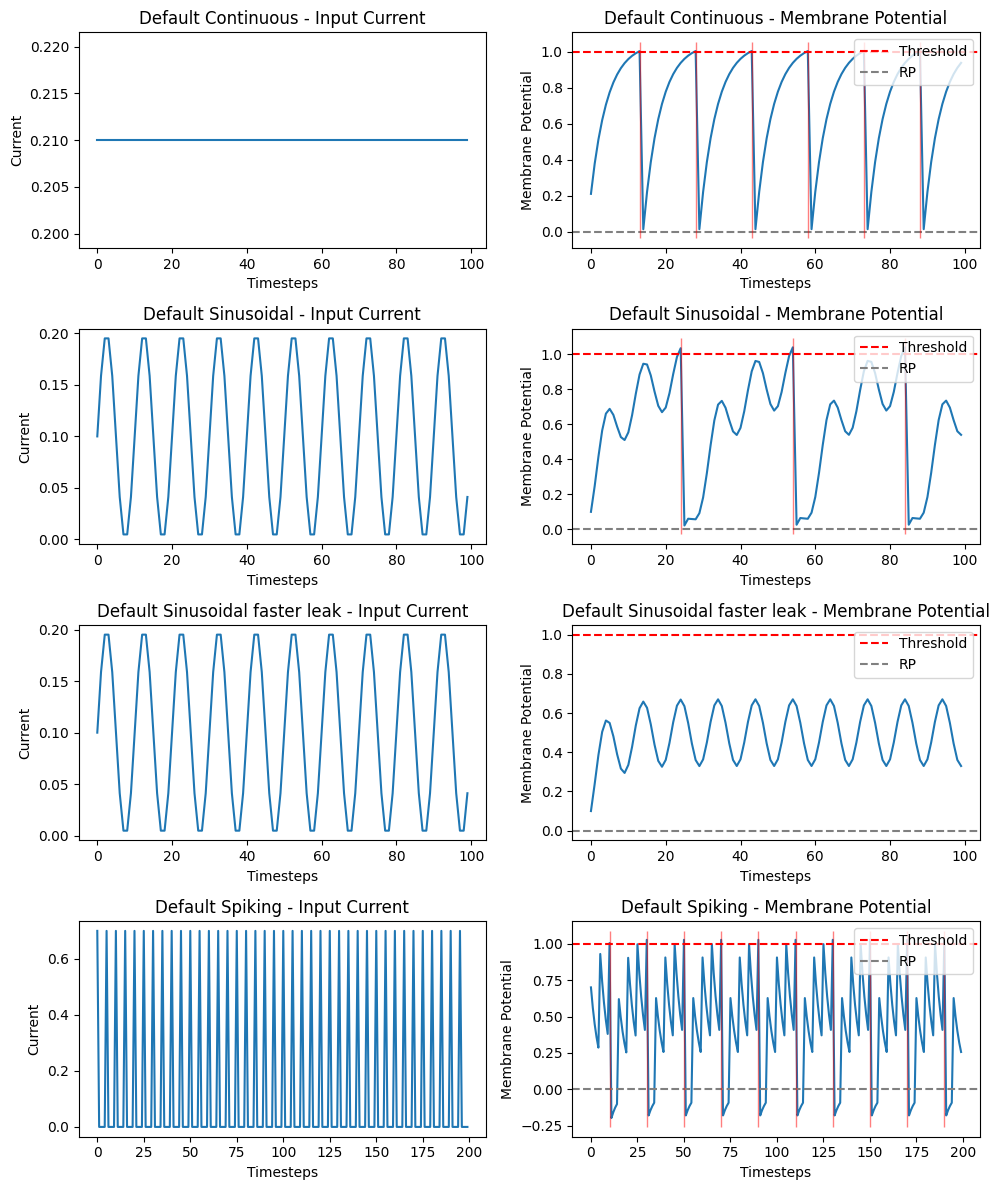

In [ ]:
# Create a dictionary of parameter sets
SimParams = namedtuple(
    "SimParams",
    [
        "beta",
        "v_threshold",
        "steps",
        "frequency",
        "strength",
        "input_type",
    ],
)
param_sets = {
    "Default Continuous": SimParams(
        beta=0.8,
        v_threshold=1,
        steps=100,
        frequency=0.1,
        strength=0.21,
        input_type="continuous",
    ),
    "Default Sinusoidal": SimParams(
        beta=0.89,
        v_threshold=1,
        steps=100,
        frequency=0.1,
        strength=0.2,
        input_type="sinusoidal",
    ),
    "Default Sinusoidal faster leak": SimParams(
        beta=0.8,
        v_threshold=1,
        steps=100,
        frequency=0.1,
        strength=0.2,
        input_type="sinusoidal",
    ),
    "Default Spiking": SimParams(
        beta=0.8,
        v_threshold=1,
        steps=200,
        frequency=0.2,
        strength=0.7,
        input_type="spiking",
    ),
}

# Run simulations and store results
results = {}
for label, params in param_sets.items():
    results[label] = run_simulation(params)
# Plot the results
plot_results(results, param_sets)

The first plot **"Default Continuous"** shows a neuron that receives a continuous input and steadily increases its input until it reaches the threshold for firing. When the threshold is reached, it gets reset and the potential starts to raise anew. Here, the decay and the strength of the input are balanced in a way that the decay does not outgrow the strength of the input before the membrane potential reaches the threshold allowing for this regular spiking pattern.

The second plot **"Default Sinusoidal"** shows a neuron with some sub-threshold oscillations before the neuron reaches the firing threshold. These oscillations stem from the pattern of the input current and from the decay, which is small enough so that the membrane potential is still able to rise over the course of the input cycles. 

The third plot **"Default Sinusoidal faster leak"** is based on very similar parameters as the second plot and beautifully illustrates the effect of the decay. The decay term for this neuron is smaller, therefore there is more decay and the membrane potential is not able to reach the firing threshold with the strength of the input current.

The fourth plot **"Default Spiking"** again shows a neuron with some subthreshold dynamics which reaches the firing threshold at every fourth input spike. Since there is no input after the neuron reaches the firing threshold, the membrane potential falls under the resting potential (grey) line, since the reset term and the decay are applied at the same time.

Feel free to play around with the parameters now and explore what behavior you can create with the model!

### 2.2 Reservoir Computing Demo

In this part of the demo you can take the different datasets you have generated in the first part and use them to train a reservoir network. For the reservoir part of the demo we make use of the reservoir implementation of the [reservoirpy](https://reservoirpy.readthedocs.io/) Python package.

If you remember from the lecture, a reservoir network is a type of recurrent neural network used in reservoir computing. It consists of a fixed, randomly connected hidden layer of neurons, called the reservoir, which processes input data in a dynamic, non-linear manner. 

The reservoir’s internal states evolve over time, generating a high-dimensional representation of the input, which captures complex temporal dependencies. Only the readout layer is trained, while the reservoir itself remains fixed. This simplifies the training process, as only the readout weights are learned, making it efficient for tasks involving temporal data.

Below is an example of a reservoir taken from reservoirpy. You can see the input going into the network the feedback connections within, and the readout on the right.

![alt text](img/reservoir.png)

In [ ]:
from reservoirpy.nodes import Reservoir, Ridge
from utils.utils import reservoir_dict_to_str, plot_results, reservoir_dict_to_int, plot_reservoir_data, plot_reservoir_activations, plot_reservoir_predictions

### 2.2.1 Choosing the input configuration

To begin, let us define the data we want to use when playing around with the reservoir later. For that you have a number of options. Feel free to come back here often and change things around to see what effects a different problem might have.

- `param_set`: First you can define which dataset to use, by changing the value of the `param_set` variable to the key of the set of parameters that was used to generate it.

- Input feature and target:
    - The options here are made up of the results of the first part of the demo. You can choose between `"Timesteps"`, `"Input Current"`, `"Membrane Potential"` and `"Spikes"`
    - `reservoir_input_feature`: Here you can specify which input feature the reservoir should receive. Depending on this data, the reservoir will try to predict the values of the:
    - `reservoir_target`: The target that the reservoir will try to predict.


So that you can get a feel for the data you chose, we plot it here below this code cell.

In [ ]:
# Define the data which will be used to train the reservoir
param_set = "Fast Decay" # Options: The labels of the param_sets dictionary, e.g. "Default", "Fast Decay", "Spikes", or any custom ones you have created
reservoir_input_feature = "Input Current" # Options: "Timesteps", "Input Current", "Membrane Potential", "Spikes"
reservoir_target = "Spikes" # Options: "Timesteps", "Input Current", "Membrane Potential", "Spikes"

# Define input and target data
x_train = results[param_set][reservoir_dict_to_int(reservoir_input_feature)].numpy().reshape(-1, 1)
y_train = results[param_set][reservoir_dict_to_int(reservoir_target)].numpy().reshape(-1, 1)

# Plot the input and target data
plot_reservoir_data(x_train, y_train, reservoir_input_feature, reservoir_target)

### 2.2.2 Reservoir activations

Now that we have the data, we can already instantiate our reservoir. Using reservoirpy, this is very easy. We create a basic reservoir with 100 units, a leak rate of 0.5 and a spectral radius of 0.9. Then, we feed it for 50 timesteps (or less if your data is shorter).

Finally, we plot the activations of 20 of the reservoirs neurons. Here, even without any training, you can see obvious differences in the reservoirs response to different datasets. The response to a continuous stimulus for example, will be much more stable than the activations of the reservoir reacting to a sine wave.

In [ ]:
# Create and feed the reservoir
reservoir = Reservoir(100, lr=0.5, sr=0.9)
reservoir_states = reservoir.run(x_train[:50])

# Plot the reservoir activations
plot_reservoir_activations(reservoir_states)

### 2.2.3 Reservoir model instantiation and training
Now we can proceed with creating and training a proper reservoir model. A model in reservoirpy consists of multiple combined nodes. With the `>>` operator we can instantiate the model such that information flows from the reservoir to the readout node. We will use the `Reservoir` and `Ridge` classes from the `reservoirpy` package to build our model. You already know the ``Reservoir`` class. The `Ridge` node will act as a readout layer. The reservoir has 200 units, a leak rate of 0.6, and a spectral radius of 0.9. The readout layer uses ridge regression with a regularization parameter of 1e-7.

After defining the model, we  fit it to our training data with a warmup period of 10 timesteps. This warmup period allows the reservoir to stabilize before training the readout layer.

In [ ]:
# Initialize the reservoir and readout nodes
reservoir = Reservoir(200, lr=0.6, sr=0.9)
readout = Ridge(ridge=1e-7)

# Create the reservoir model by defining the connections between the reservoir and readout
reservoir_model = reservoir >> readout

# Train the reservoir model
reservoir_model.fit(x_train, y_train, warmup=10)

### 2.2.4 Reservoir prediction
Now that we have trained our reservoir model, we can use it to make predictions. In the following code, we run the model on the first 70 timesteps of the training data and plot the predictions against the actual target values. This will help us visualize how well the reservoir model has learned to predict the target feature based on the input feature.

Depending on your choices of dataset, input feature and target, the performance of the reservoir will vary drastically.

For example, as mentioned above, the activations in the reservoir will be quite stable if your input data is a continuous value, which will usually not provide much information to the readout layer in order for it to learn to predict e.g. the membrane potential.

The response to sinoid or spiking input data on the other hand might be more interesting. Give it a try!

In [ ]:
y_pred = reservoir_model.run(x_train[:70])

plot_reservoir_predictions(
    x_train, y_train, y_pred, reservoir_input_feature, reservoir_target
)

## 3. Sources

* Gerstner, W., Kistler, W. M., Naud, R., & Paninski, L. (2014). _Neuronal dynamics: From single neurons to networks and models of cognition._ Cambridge University Press.
* Yamazaki, K., Vo-Ho, V. K., Bulsara, D., & Le, N. (2022). Spiking neural networks and their applications: A review. _Brain Sciences_, 12(7), 863.
* _Ohm's law_. (n.d.) Wikipedia. Retrieved September 30, 2024 from https://en.wikipedia.org/wiki/Ohm%27s_law
* _Capacitor_. (n.d.) Wikipedia. Retrieved September 30, 2024 from https://en.wikipedia.org/wiki/Capacitor
